In [1]:
# import libraries
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from unityagents import UnityEnvironment

In [2]:
# import libraries
import config
from util.utils import OUNoise, ReplayBuffer
from modules.actor import Actor
from modules.critic import Critic

In [3]:
# init
os.makedirs(config.SAVE_DIRECTORY, exist_ok=True)

In [4]:
# load game environment
env = UnityEnvironment(file_name=config.UNITY_ENVIRONMENT_PATH, no_graphics=config.UNITY_NO_GRAPHIC, worker_id=config.UNITY_WORKER_ID)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=True)[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [5]:
# extract game configuration
num_agents = len(env_info.agents)
states = env_info.vector_observations
input_dims = states.shape[1]
action_dims = brain.vector_action_space_size

In [6]:
# initialise modules
memory = ReplayBuffer()
noise = OUNoise(action_dims)
actorA = Actor(input_dims, action_dims, memory, noise)
actorB = Actor(input_dims, action_dims, memory, noise)
critic = Critic(input_dims, action_dims)

In [7]:
# create training function
def train(n_episodes, num_agents, score_buffer=100):

    # init
    scores = []
    scores_window = deque(maxlen=score_buffer)
    
    # start training
    for eps in range(n_episodes):

        # re-init
        actorA.reset()
        actorB.reset()  
        score = np.zeros(num_agents)

        # reset env
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        
        # iterating within single episode
        while True:

            # get optimal actions based on latest agent policy
            action_0 = actorA.act(states[0])
            action_1 = actorB.act(states[1])
            actions = np.concatenate((action_0, action_1))
        
            # execute actions
            env_info = env.step(actions)[brain_name]                       
            next_states = env_info.vector_observations  
            rewards = env_info.rewards
            dones = env_info.local_done

            # learn from actions
            actorA.step(states[0], action_0, rewards[0], next_states[0], dones[0])
            actorB.step(states[1], action_1, rewards[1], next_states[1], dones[1])
            critic.step(actorA, memory)
            critic.step(actorB, memory)

            # store rewards
            score += rewards
        
            # stop iteration if it reach terminal                                                        
            if np.any(dones):   
                break                                        

            # setting preparation for next iteration
            states = next_states       

        # save score into log and buffer
        scores.append(np.max(score))
        scores_window.append(np.max(score))
        print("episode: {}/{}   score: {}   best average score: {}".format(eps, n_episodes, np.max(score), np.mean(scores_window)), end="\r")
        
        # stop if environment is solved
        if np.mean(scores_window) >= 0.5:
            print("environment solved in {} episode with average score = {}".format(eps, np.mean(scores_window)))
            torch.save(actorA.local.state_dict(), '{}/actorA_model.pth'.format(config.SAVE_DIRECTORY))
            torch.save(actorB.local.state_dict(), '{}/actorB_model.pth'.format(config.SAVE_DIRECTORY))
            torch.save(critic.local.state_dict(), '{}/critic_model.pth'.format(config.SAVE_DIRECTORY))
            break
    
    return scores

# start training
scores_log = train(config.N_EPISODES, num_agents)

/home/junkit2/.local/lib/python3.6/site-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


environment solved in 480 episode with average score = 0.50360000751912596000075191259375


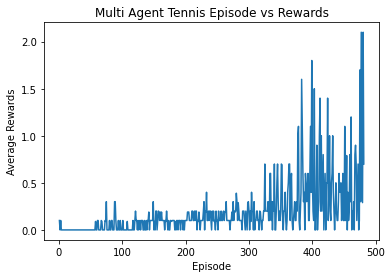

In [8]:
# plot results
x = np.arange(1, len(scores_log)+1)
y = scores_log
plt.plot(x, y)
plt.title("Multi Agent Tennis Episode vs Rewards")
plt.xlabel("Episode")
plt.ylabel("Average Rewards")
plt.show()